In [1]:
!pip install pykan torch numpy matplotlib scikit-learn tqdm sympy setuptools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim
from kan import KAN
import math
import os


In [3]:
# Initialize constants
Omega_val = 2 * np.pi  
omega_val = Omega_val * 1.5 
lambda_val = omega_val / 2 
gamma_val = 1.01
omegaSQ_val = omega_val ** 2
f_val = gamma_val * omegaSQ_val


In [4]:
# Differential equation helper function for solve_ivp
def helper(t, theta):
    theta, z = theta
    dthetadt = [z, f_val * math.cos(Omega_val * t) - omegaSQ_val * math.sin(theta) - lambda_val * z]
    return dthetadt


In [5]:
# Initial conditions
initial_conditions = [0, 0]
start_val = 0
end_val = 15

# Time points
t = np.linspace(start_val, end_val, 3000)

# Solve the differential equation using solve_ivp
sol = solve_ivp(helper, [start_val, end_val], initial_conditions, t_eval=t, method='LSODA', rtol=1e-6, atol=1e-8)


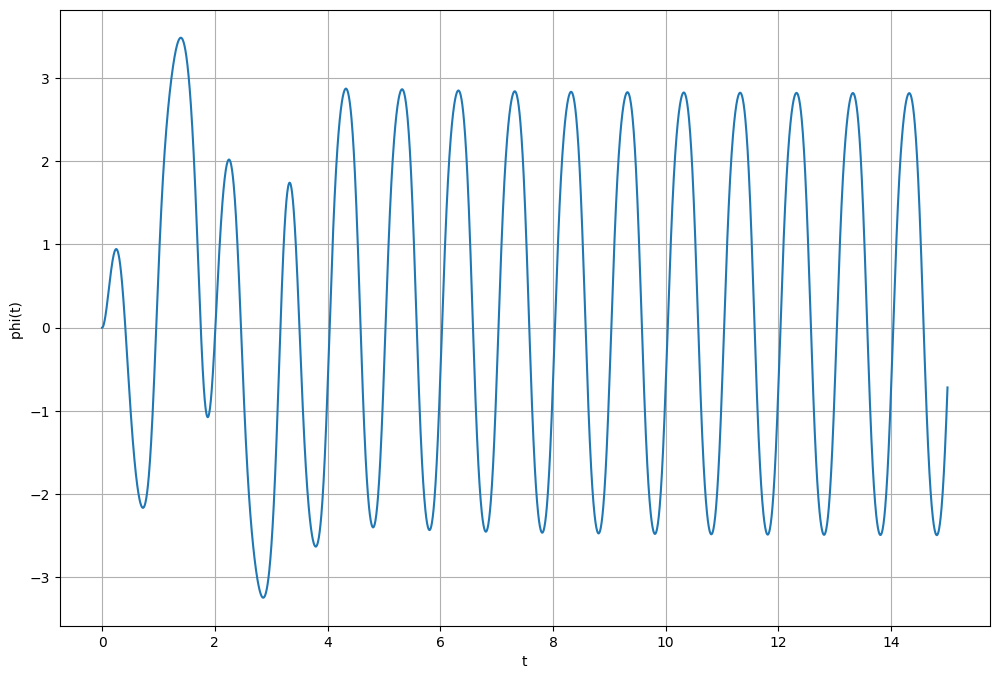

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(sol.t, sol.y[0], label='Numerical Solution')
plt.xlabel('t')
plt.ylabel('phi(t) ')
plt.grid(True)
plt.savefig('numerical_only.png')
plt.show()

In [7]:
# Save ODE solver results to CSV
ode_df = pd.DataFrame({'t': sol.t, 'theta': sol.y[0], 'omega_dot': sol.y[1]})
ode_df.to_csv('ode_solver_results.csv', index=False)


In [8]:
# Define a separate time interval for the neural network training
nn_start_val = 0
nn_end_val = 15
nn_t = np.linspace(nn_start_val, nn_end_val, 14000)

# Prepare training data based on the new time interval
x_physics = torch.tensor(nn_t, dtype=torch.float32).view(-1, 1)
y_physics = torch.tensor(np.interp(nn_t, t, sol.y[0]), dtype=torch.float32).view(-1, 1)

In [9]:
physics_weight = 1e-3
# Define the KAN model
model = KAN(width=[1,8,5,8,1], grid=5, k=3, seed=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()


checkpoint directory created: ./model
saving model version 0.0


In [10]:
# Convert constants to torch.Tensor
Omega = torch.tensor(Omega_val, dtype=torch.float32)
omega = torch.tensor(omega_val, dtype=torch.float32)
lambda_ = torch.tensor(lambda_val, dtype=torch.float32)
gamma = torch.tensor(gamma_val, dtype=torch.float32)  
omegaSQ = torch.tensor(omegaSQ_val, dtype=torch.float32)
f = torch.tensor(f_val, dtype=torch.float32)


In [11]:
# Training loop
epochs = 35000
losses = {'total_loss': [], 'boundary_loss': [], 'physics_loss': []}

patience = float('inf')  # Set patience to infinity to disable early stopping
best_loss = float('inf')
early_stop_counter = 2000
best_model_state = None
best_epoch = -1  # Variable to store the epoch with the best loss

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(x_physics)
    
    # Compute boundary loss (initial condition)
    boundary_loss = criterion(outputs[0], torch.tensor([initial_conditions[0]], dtype=torch.float32))
    
    # For simplicity, we'll consider physics loss as the total loss in this context
    physics_loss = criterion(outputs, y_physics)
    
    # Total loss
    total_loss = boundary_loss + physics_loss
    total_loss.backward()
    optimizer.step()
    
    losses['total_loss'].append(total_loss.item())
    losses['boundary_loss'].append(boundary_loss.item())
    losses['physics_loss'].append(physics_loss.item())

    # Early stopping logic and model state saving
    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        early_stop_counter = 0
        
        # Save the best model state
        best_model_state = model.state_dict()
        best_epoch = epoch  # Save the epoch number
        
    else:
        early_stop_counter += 1

    if early_stop_counter > patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Print progress
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {total_loss.item():.4f}')

# Restore the best model state after training
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f'Restored model to epoch {best_epoch+1} with best loss: {best_loss:.4f}')

Epoch [1000/35000], Total Loss: 2.0290
Epoch [2000/35000], Total Loss: 2.4254
Epoch [3000/35000], Total Loss: 2.3214
Epoch [4000/35000], Total Loss: 2.2384
Epoch [5000/35000], Total Loss: 2.2786
Epoch [6000/35000], Total Loss: 2.1696
Epoch [7000/35000], Total Loss: 1.9922
Epoch [8000/35000], Total Loss: 1.9327
Epoch [9000/35000], Total Loss: 1.9091
Epoch [10000/35000], Total Loss: 1.8750
Epoch [11000/35000], Total Loss: 1.8923
Epoch [12000/35000], Total Loss: 1.8603
Epoch [13000/35000], Total Loss: 1.8578
Epoch [14000/35000], Total Loss: 1.8417
Epoch [15000/35000], Total Loss: 1.8333
Epoch [16000/35000], Total Loss: 1.7520
Epoch [17000/35000], Total Loss: 1.7245
Epoch [18000/35000], Total Loss: 1.7282
Epoch [19000/35000], Total Loss: 1.7132
Epoch [20000/35000], Total Loss: 1.6781
Epoch [21000/35000], Total Loss: 1.6707
Epoch [22000/35000], Total Loss: 2.3001
Epoch [23000/35000], Total Loss: 2.1594
Epoch [24000/35000], Total Loss: 2.0273
Epoch [25000/35000], Total Loss: 2.0112
Epoch [26

In [12]:
# Print final losses
print("\nFinal Losses:")
print(f"Total Loss: {losses['total_loss'][-1]:.4f}")
print(f"Boundary Loss: {losses['boundary_loss'][-1]:.4f}")
print(f"Physics Loss: {losses['physics_loss'][-1]:.4f}")



Final Losses:
Total Loss: 2.2155
Boundary Loss: 0.0000
Physics Loss: 2.2155


In [13]:
# Save loss values to CSV
loss_df = pd.DataFrame(losses)
loss_df.to_csv('kan_loss_values.csv', index=False)


In [14]:
# Predict using the KAN model
y_kan = model(x_physics).detach().numpy()
kan_df = pd.DataFrame({'t': nn_t, 'theta': y_kan.squeeze()})
kan_df.to_csv('kan_results.csv', index=False)

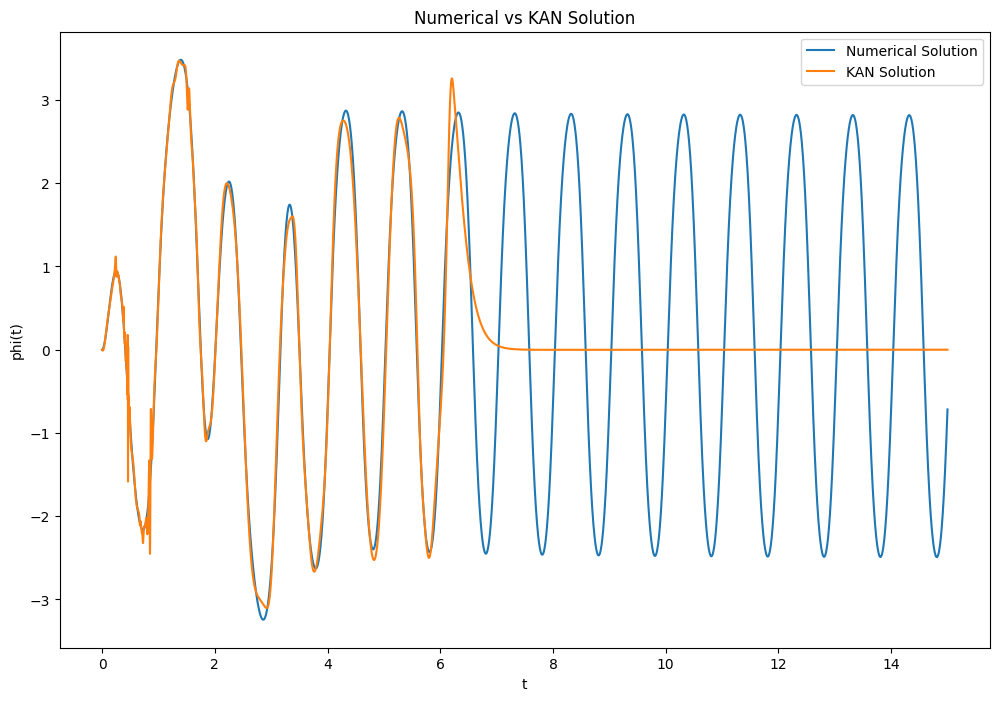

In [15]:
# Plot both the numerical and KAN solutions 
plt.figure(figsize=(12, 8))  
plt.plot(sol.t, sol.y[0], label='Numerical Solution')
plt.plot(nn_t, y_kan, label='KAN Solution')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('Numerical vs KAN Solution')
plt.savefig('/kaggle/working/KAN_vs_Numerical.png')
plt.show()

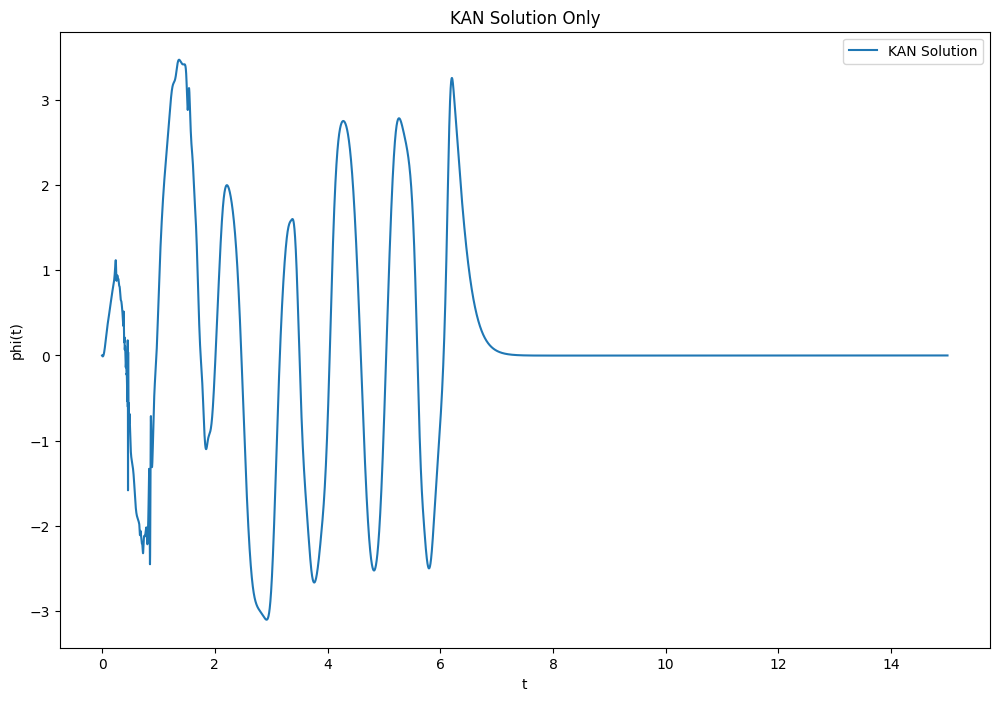

In [16]:
# Plot KAN solution only
plt.figure(figsize=(12, 8))  
plt.plot(nn_t, y_kan, label='KAN Solution')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('KAN Solution Only')
plt.savefig('/kaggle/working/KAN_only.png')
plt.show()

In [17]:
# Plot the KAN grid before pruning
model.plot(scale=10)
plt.savefig('/kaggle/working/KAN_before_prune.png')

In [18]:
# Plot the KAN grid after automatic pruning
model_pruned=model.prune()
model_pruned(x_physics)
model_pruned.plot(scale=10)
plt.savefig('/kaggle/working/KAN_after_prune.png')

saving model version 0.1


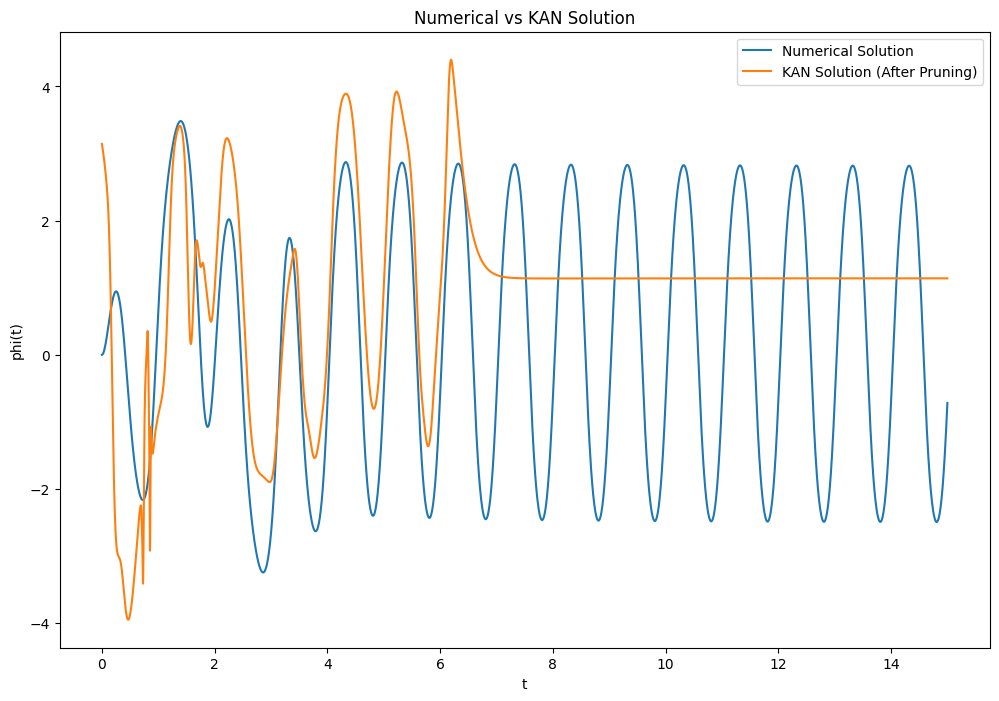

In [19]:
# Predict using the KAN model
y_kan_prune = model_pruned(x_physics).detach().numpy()
kan_df_prune = pd.DataFrame({'t': nn_t, 'theta': y_kan_prune.squeeze()})
kan_df_prune.to_csv('kan_results_pruned.csv', index=False)

# Plot both the numerical and KAN solutions (KAN after pruningsdx)
plt.figure(figsize=(12, 8))  
plt.plot(sol.t, sol.y[0], label='Numerical Solution')
plt.plot(nn_t, y_kan_prune, label='KAN Solution (After Pruning)')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('Numerical vs KAN Solution')
plt.savefig('/kaggle/working/KAN_vs_numerical.png')
plt.show()

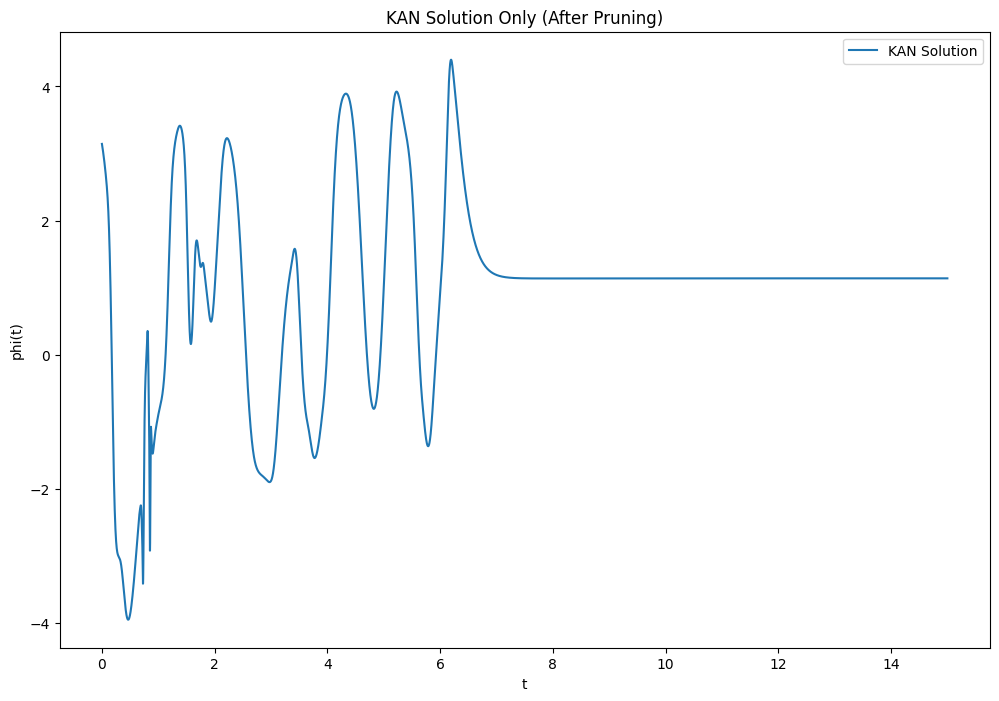

In [20]:
# Plot only the KAN solution after pruning
plt.figure(figsize=(12, 8))
plt.plot(nn_t, y_kan_prune, label='KAN Solution')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('KAN Solution Only (After Pruning)')
plt.savefig('/kaggle/working/KAN_only.png')
plt.show()